# exploration 12. 한국어 데이터로 챗봇 만들기  
  
<b>transformer</b>를 활용하여 한국어 데이터로 챗봇을 만들어보자.  
***  
### 챗봇을 만드는 과정  
1. 데이터 수집하기: 한국어 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.[데이터 주소](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)  
2. 데이터 전처리하기  
3. subwordtextencoder 사용하기  
4. 트랜스포머 모델 구성하기  
5. 모델 평가하기  
***
### 트랜스포머(transformer)  
2017년 구글이 발표한 논문으로 nlp 딥러닝 분야에서 state-of-the-art(SOTA)를 달성했고 3만회 이상 인용되었다. <b>트랜스포머의 특징은 RNN을 사용하지 않고 multi-head self-attention을 활용해 sequential computation을 줄여 병렬 처리가 가능하게 만들고 단어들 간에 dependency를 모델링한다는 것이다.</b>  
***
음... 프로젝트에 들어가기 앞서 트랜스포머에 관한 내용은 [내 블로그](https://velog.io/@mindy1147/Transformer)에 정리했습니다. 한 번 들어가셔서 내용을 읽어주시면 감사하겠습니다.  
이번 프로젝트는 내용과 코드 모두 어려웠기 때문에 이론은 블로그에 따로 정리하고 여기서는 코드를 이해하는데 더 집중하기로 했습니다.  
사실 따지고 보면 논문을 이해하고 이를 구현한거나 마찬가지네요. 저 같은 딥린이에게는 어마어마한 프로젝트입니다. 그럼 시작하겠습니다!  
***
### Chatbot_data  
해당 데이터는 다음카페 "[사랑보다 아름다운 실연](http://cafe116.daum.net/_c21_/home?grpid=1bld)"에서 자주 나오는 이야기들을 참고하여 제작했다고 합니다.  
질문에 대해 챗봇이 위로한다는 취지로 제작하셨습니다. 데이터의 구성은 다음과 같습니다.  
1.챗봇 트레이닝용 문답 페어 11876개(질문, 정답)  
2.label은 총 3가지로 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2 로 구성됩니다. 
***
### ※전처리 및 챗봇 평가 코드는 위키독스의 트랜스포머를 이용한 한국어 챗봇 튜토리얼을 참고하여 작성했습니다.  
[위키독스 트랜스포머를 이용한 한국어 챗봇](https://wikidocs.net/89786)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf

# 1.데이터 가져오기  

데이터는 클라우드에 저장하지 않고 request로 불러오겠습니다.  
***
●<b>urllib.request</b>  
→url 주소의 문서를 열고 읽기 위해 사용하는 모듈  
***
●<b>urlretrieve</b>  
→URL로 표시된 네트워크 객체(URL 주소의 문서)를 로컬 파일로 저장, 직접 다운로드가 가능하다.  
→urllib.request.urlretrieved(url, 로컬에 저장될 파일 이름)

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
print('챗봇 샘플의 개수 :', len(train_data)) 

챗봇 샘플의 개수 : 11823


총 샘플의 개수는 11,823개 입니다. Null 값이 있는지 확인합니다. 

In [4]:
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


null 값이 없습니다. 

# 2.데이터 전처리
### SubwordTextEncoder(서브워드텍스트인코더)
서브워드텍스트인코더는 텐서플로우를 통해 사용할 수 있는 서브워드 토크나이저이다.  
BPE와 유사한 알고리즘인 Wordpiece Model을 채택했으며, 패키지를 통해 내부 단어 분리 기능을 지원한다. 
***
이번 프로젝트에는 토크나이징을 위한 형태소 분석기를 사용하지 않고 <b>SubwordTextEncoder</b>를 그대로 사용합니다.  
따라서 전처리도 그에 맞게 처리해줍니다. 기존 lstm이나 seq2seq 모델을 위한 전처리 방법 보다 간단한 작업입니다. 
raw data에서 ?,.,! 같은 구두점 앞에 띄어쓰기를 추가하여 다른 문자들과 구분합니다.  
예를들어 '12시 땡!' 문장은 전처리 후 '12시 땡 !'으로 변하게 됩니다.  
이러한 전처리는 질문 데이터와 답변 데이터 모두에 적용해줍니다. 

In [3]:
#질문 데이터 전처리
questions = [] #질문을 담을 리스트 
for sentence in train_data['Q']: #Q열에 해당하는 데이터 불러오기 
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) #구두점 앞에 띄어쓰기
    sentence = sentence.strip() #양쪽 공백제거
    questions.append(sentence) #전처리된 데이터 저장 

In [4]:
#답변 데이터 전처리
answers = [] #답변 담을 리스트
for sentence in train_data['A']: #A열에 해당하는 데이터 불러오기 
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 구두점에 대해서 띄어쓰기
    sentence = sentence.strip() #양쪽 공백제거
    answers.append(sentence) #전처리된 데이터 저장 

질문과 대답에 대해서 상위 5개만 출력하여 구두점들이 띄어쓰기를 통해 분리되었는지 확인합니다.

In [7]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


# 3.단어 집합 생성
<b>SubwordTextEncoder</b>:서브워드 단위로 토큰을 분리하는 토크나이저로 학습 데이터로부터 학습하여 서브워드로 구성된 단어 집합(Vocabulary)을 생성합니다.  
1. 단어집합 생성(토크나이저)  
2. 시작 토큰 SOS와 종료 토큰 EOS에 정수 부여 

In [5]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13) #단어집합 생성(토크나이저), target_vocab_size는 생성할 단어 집합 사이즈 결정 

In [6]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [10]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


# 4.정수 인코딩과 패딩
<b>SubwordTextEncoder</b>의 토크나이저로 정수 인코딩을 진행합니다. 이는 토크나이저의 encode()를 사용하여 가능합니다. 반대로 정수 인코딩을 기존 텍스트 시퀀스로 복원할 수 있는데 이는 decode()로 가능합니다.  

### 4-1.10번 샘플 데이터 인코딩과 디코딩

In [7]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[10] #10번 질문 샘플로 진행합니다 

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5779, 484, 194, 2984, 45, 3818]
기존 문장: SNS보면 나만 빼고 다 행복해보여


인코딩 안에 정수가 6개 존재하는데 기존 문장의 띄어쓰기 단위인 어절은 5개만 존재 합니다.  
이런 경우 'SNS보면' 같은 한 어절이 두 개 이상의 정수일 수 있음을 알려줍니다.  

In [8]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5779 ----> SNS
484 ----> 보면 
194 ----> 나만 
2984 ----> 빼고 
45 ----> 다 
3818 ----> 행복해보여


### 4-2.전체 데이터에 대해 정수 인코딩 + 패딩
<b>tokenize_and_filter()</b> 함수는 정수 인코딩과 패딩을 진행합니다.  
임의로 패딩의 길이는 40으로 정합니다.  

In [9]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩 / 최대 길이 초과하는 샘플 제거
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH: #최대 길이 40 이하인 경우에만 데이터셋으로 허용
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩 
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [10]:
questions, answers = tokenize_and_filter(questions, answers) #tokenize_and_filter함수에 질문과 답변 인수로 넘겨 정수인코딩과 패딩 진행

#### 최대 길이 초과하는 샘플 제거하지 않았을 때 데이터 크기 확인

In [15]:
#정수 인코딩과 패딩이 진행된 후의 데이터 크기를 확인 
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 40)
답변 데이터의 크기(shape) : (11823, 40)


#### 최대 길이 초과하는 샘플 제거했을 때 데이터 크기 확인

In [16]:
#최대 길이 40을 초과하는 데이터 제거 후 데이터 크기 확인
print('단어장의 크기 :',(VOCAB_SIZE))
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

단어장의 크기 : 8180
질문 데이터의 크기(shape) : (11823, 40)
답변 데이터의 크기(shape) : (11823, 40)


최대 길이를 초과하는 샘플 제거 했을 때나 제거 하지 않았을 때나 데이터 크기는 동일하다.

In [17]:
# 0번 샘플을 임의로 출력 
print(questions[0])
print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


길이 맞추기 위해 뒤에 0이 패딩된 것을 확인할 수 있다.  

# 5.인코더와 디코더의 입력, 레이블 만들기
<b>tf.data.Dataset</b>을 사용하여 데이터를 배치 단위로 불러오기  
***
### tf.data.Dataset.from_tensor_slices
tensorflow의 Dataset이라는 built-in-API는 입력 파이프라인을 만들어서 모델에 데이터를 효율적으로 공급하는 방법으로 GPU에 들어올 데이터를 멈춰있지 않게 해준다.  
즉, 데이터를 로드하는 bottleneck 시간이 줄어들어 학습 시간이 줄어듦  
<b>tf.data.Dataset.from_tensor_slices</b>는 tensor를 사용해서 dataset을 초기화 할 수 있다.  
<b>cache</b>  
preprocessing 시간이 너무 길어서 줄이고 싶을 때 사용  
<b>batch</b>  
Dataset API를 사용하면 주어진 크기로 데이터 세트를 자동으로 처리하는 batch(BATCH_SIZE)메서드를 사용할 수 있다.  
<b>shuffle</b>  
shuffle을 사용하면 설정된 epoch마다 Dataset을 섞을 수 있고 overfitting을 막아준다.  
파라미터로 buffersize를 설정할 수 있다.  
<b>prefetch</b>  
학습 중에 데이터 로드 시간을 줄이기 위해 미리 메모리에 적재시키는데 얼마나 적재시킬지는 파라미터로 전달  
<b>tf.data.experimental.AUTOTUNE</b>  
prefetch의 파라미터로 네트워크가 알아서 메모리에 적재시킬 양을 정해라는 의미  
[Reference1.](https://cyc1am3n.github.io/2018/09/13/how-to-use-dataset-in-tensorflow.html)
[Reference2.](https://ko-kr.facebook.com/groups/TensorFlowKR/posts/911745229166536/)
***
#### 교사강요(Teacher Forcing) 사용하기  
교사강요란 테스트 과정에서 t시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 기법. 모델이 t시점에서 예측한 겂을 t+1 시점에 입력으로 사용하지 않고, t시점의 레이블. 즉, 실제 알고 있는 정답을 t+1 시점의 입력으로 사용합니다.  
이는 훈련 과정에서 한 번 잘못 예측하면 뒤에서의 예측까지 영향을 미쳐 훈련 시간이 느려지게 되는 것을 방지한다.  

In [11]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다. 이전의 target을 다음의 input으로 사용 
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.(START_TOKEN)
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 6.트랜스포머 모델 구현  
### 6-1.포지셔널 인코딩 레이어
●get_angles함수  
pos, i, d_model 입력 받아 positional encoding 계산  
아래 공식을 구현  
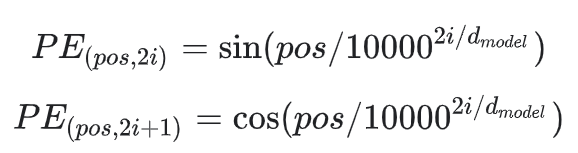  
●tf.stack:여러 조각의 행렬을 합칠 때 사용  
●tf.transpose:텐서의 형과 열 전치  
●tf.reshape:텐서의 형태 변환

In [12]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

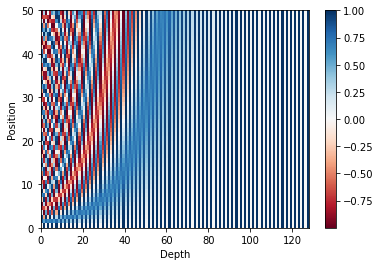

In [13]:
#문장의 길이 50, 임베딩 벡터의 차원 128
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 6-2.스케일드 닷 프로덕트 어텐션 함수  
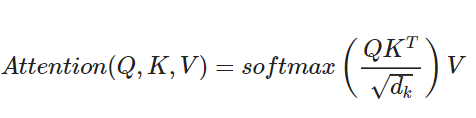  
***  
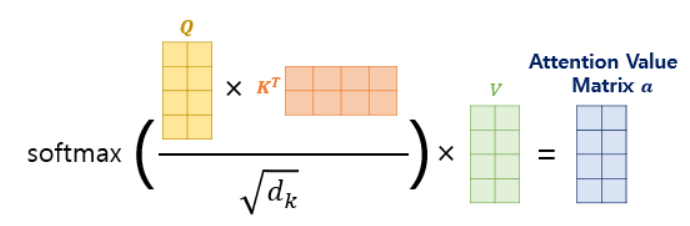

●입력으로 들어온 문장 행렬 크기는 (seq_len, d_model) Q와 K 벡터의 차원은 d_k이고 V 벡터의 차원을 d_v라고 할 때,  
Q와 K 행렬의 크기는 (seq_len, d_k)이며 V 행렬의 크기는 (seq_len, d_v)가 됨.  
●가중치 행렬 WQ와 WK는 (d_model, d_k) 크기를 가지며 WV는 (d_model, d_v)의 크기를 가진다.  
●d_k와 d_v는 d_model/num_heads=d_k=d_v와 같이 구한다.  
●어텐션 값 행렬 a의 크기는 (seq_len, d_v)이 됨

In [14]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱. 어텐션 스코어 행렬.
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 스케일링
    # dk의 루트값으로 나눠준다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)

    return output


### 6-3. multiheadattention 구현
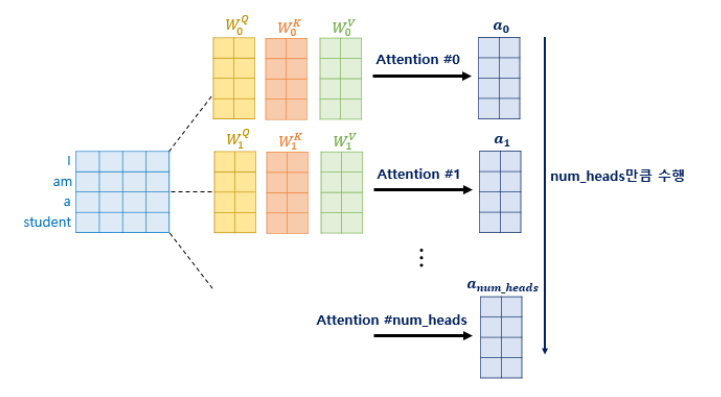  
***


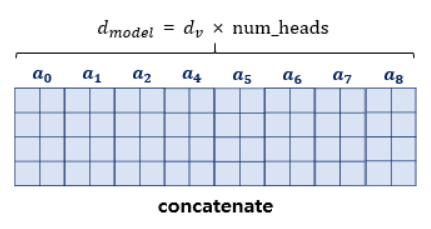  
***  
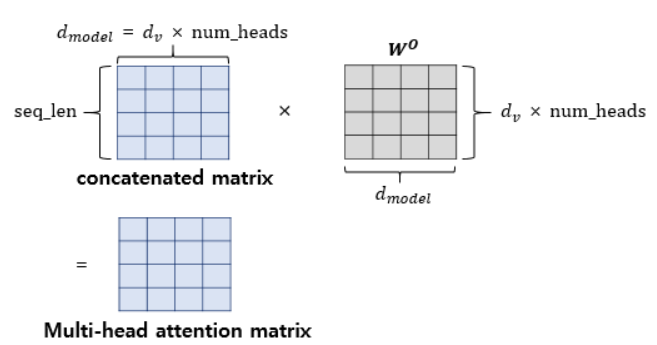  
***  

●멀티 헤드 어텐션(Multi-head Attention)은 Q, K, V 행렬을 만들기 위한 가중치 행렬인 WQ, WK, WV 행렬과 WO(어텐션 헤드들을 concatenation 후에 곱해줌) 행렬의 두가지 가중치 행렬을 가짐  
●가중치 행렬을 곱하는 것은 Dense(units) layers에서 구현  
●멀티어텐션구현의 다섯 가지 파트  
1. WQ, WK, WV에 해당하는 d_model 크기의 밀집층(Dense layer)을 지나게한다.  
2. 지정된 헤드 수(num_heads)만큼 나눈다(split).  
3. 스케일드 닷 프로덕트 어텐션.  
4. 나눠졌던 헤드들을 연결(concatenatetion)한다.  
5. WO에 해당하는 밀집층을 지나게 한다.  

●멀티헤드어텐션 행렬은 인코더의 입력 행렬과 크기(seq_len, d_model)가 동일

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # d_model을 num_heads로 나눈 값.
        # 논문 기준 : 64
        self.depth = d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)

    # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결(concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs

### 6-4.masking (패딩 마스킹 + 룩 어헤드 마스킹)
●<b>create_padding_mask 함수</b>  
tf.math.equal(x,y,dtype):x와 y 같으면 True, 다르면 False 반환  
tf.cast:boolean 타입의 값을 0과 1로 반환  
<PAD>토큰이 존재하면 어텐션에서 제외하도록 마스킹 해줌  
어텐션 스코어 행렬에서 행에 해당하는 문장은 Query이고, 열에 해당하는 문장은 Key이다. Key에 <PAD>가 있는 경우 해당 열 전체를 마스킹하는데 이때 마스킹 위치에 매우 작은 음수 값을 입력하고 소프트맥스를 지난 후 해당 위치 값은 0이 된다.  
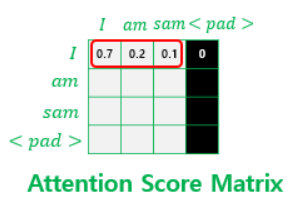  
***  
●<b>create_look_ahead_mask 함수</b>  
<b>tf.shape:</b>입력 텐서의 모형 반환  
<b>tf.linalg.band_part(input, num_lower, num_upper, name=None):</b>삼각행렬 또는 대각행렬 구현  
num_lower가 음수일 경우 --> 하삼각행렬, 해당 프로젝트에서는 seq_len x seq_len의 정발행렬에 대하여 하삼각행렬을 반환  
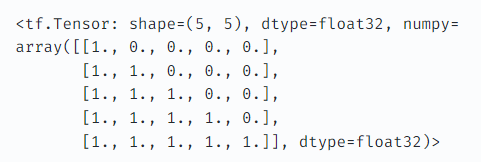  

num_upper가 음수일 경우 --> 상삼각행렬  
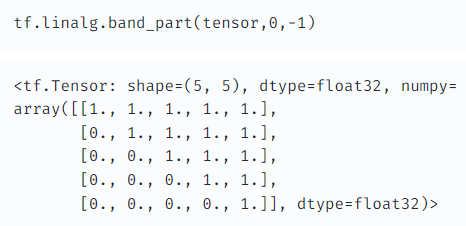  

num_lower, num_upper 모두 0일 경우 --> 대각행렬  
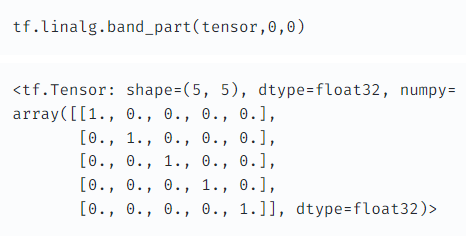  
[Reference](https://velog.io/@luckydl21/tensorflowtf.linalg.bandpart)



In [16]:
#패딩 마스킹
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, key의 문장 길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

#룩 어헤드 마스킹
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
    return tf.maximum(look_ahead_mask, padding_mask)

### 6-5.encoder layer 구현(이 레이어가 쌓여서 encoder를 구성)  
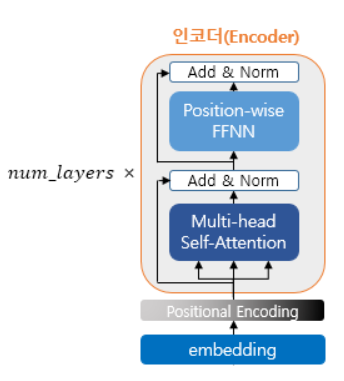  

하나의 인코더 층은 2개의 서브층(sublayer)로 나눠지는데 이는 멀티헤드셀프어텐션과 포지션피드포워드 신경망이다.  
1. Input에 대한 패딩 마스크 적용  
2. 멀티 헤드 셀프 어텐션(셀프 어텐션 병렬적으로 사용)  
   -query, key, value, mask 입력받음  
3. drouput과 layernormalization layer(layernormalization에 residual connection 사용)  
4. position-wise-FFNN(포지션와이즈피드포워드 신경망)  
5. drouput과 layernormalization layer(layernormalization에 residual connection 사용)


*** 
#### 포지션-와이즈 피드 포워드 신경망(Position-wise FFNN)  
●완전 연결 FFNN(Fully-connected FFNN)  
●x:multiheadattention 결과로 나온 (seq_len, d_model)의 크기를 가지는 행렬  
●d_ff:은닉층의 크기  
●W1:(d_model, d_ff)의 크기를 가짐  
●W2:(d_ff, d_model)의 크기를 가짐  
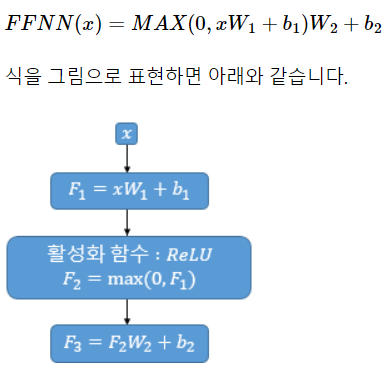


***  
#### Residual connection 
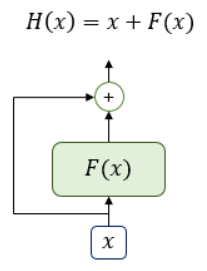  
일반적으로 잔차 연결은 H(x) = x + F(x)로 입력 값과 함수 F(x) 값을 더한 것이다. 컴퓨터 비전 분야에 주로 사용되는 모델 학습을 돕는 기법이다.  
***    
●인코더와 디코더에서 쓰이는 잔차 연결의 경우 멀티헤드어텐션 입력과 멀티헤드어텐션 결과가 더해지는 방법으로 쓰인다.  
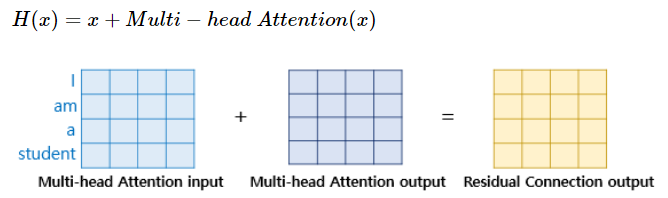

In [17]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행 + 잔차 연결
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층, 포지션 와이즈 피드 포워드 신경망
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행 + 잔차 연결
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 6-6.encoder 구현  
인코더 층을 num_layers 만큼 쌓고 마지막으로 얻는 (seq_len, d_model) 크기의 행렬을 디코더로 보냄  

In [18]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 6-7.decoder_layer  
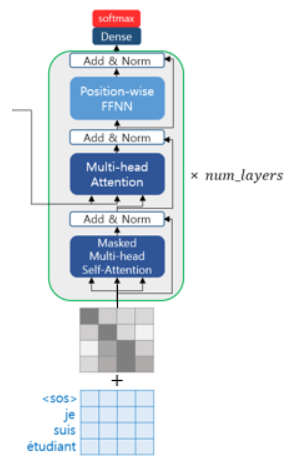  
●디코더도 인코더와 마찬가지로 임베딩층과 포지셔널 인코딩을 거친 후 문장 행렬이 입력된다. 훈련시 교사강요(Teacher Forcing)을 사용하므로 문장 행렬을 한꺼번에 입력 받음  
●이 때, 문장 행렬 전체를 입력 받으므로 현재 시점의 단어를 예측하고자 할 때 미래 시점의 단어를 참고할 수 있으므로 룩-어헤드(look-ahead mask)를 도입함  
***  
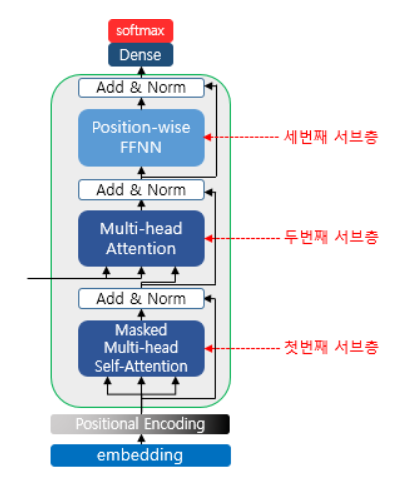  
●첫번째 서브층:멀티헤드셀프어텐션의 결과로 얻는 행렬에 룩어헤드 마스크를 적용(마스크드 셀프 어텐션)  
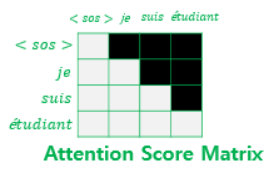


***  
●LayerNormalization, 잔차연결 적용  
●두번째서브층:인코더-디코더 어텐션, 패딩 마스크 전달  
여기서 Query는 디코더의 첫번째 서브층의 결과 행렬로부터 얻고 Key와 Value는 인코더 마지막 층 행렬로부터 얻는다.  
이후는 멀티헤드어텐션을 수행한다.  
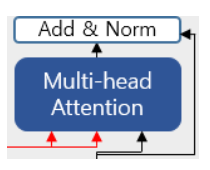  
***
●Dropout, LayerNormalization, 잔차연결 적용  
●세번째서브층:position-wise FFNN  
●Dropout, LayerNormalization, 잔차연결 적용  


In [19]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  
    #룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
      
    #패딩 마스크(두번째 서브층)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 층: 멀티 헤드 어텐션 수행 (마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs, #Q = K = V
            'mask': look_ahead_mask #룩어헤드 마스크 
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs) #잔차연결 

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1) #잔차연결 

    # 세 번째 서브 레이어 : 2개의 완전연결층, 포지션 와이즈 피드 포워드 신경망
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2) #잔차연결 

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### 6-8. decoder
positional encoding 후 디코더 층을 num_layers의 개수만큼 쌓는 코드

In [20]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    
    ## 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers): #디코더를 num_layers개 쌓기
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### 6-9.트랜스포머 모델 정의
●인코더와 디코더 조합  
●인코더의 출력은 디코더의 두번째 서브층인 인코더-디코더 어텐션에 입력으로 들어가므로 이를 전달해주는 코드 필요  
●디코더의 끝단에 있는 다중 클래스 분류 문제를 풀 수 있도록 vocab_size 만큼의 뉴런을 가지는 출력층 추가  

In [21]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    
    #인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    #디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    #디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 디코더에서 패딩을 위한 마스크(두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더의 출력은 디코더에 전달 됨 
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])#인코더의 입력은 입력 문장과 패딩 마스크 

    # 디코더의 출력은 dec_outputs 출력층으로 전달됨 
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 6-10. 모델 생성
#### 하이퍼파라미터 정하기  
<b>하이퍼파라미터는 총 5개</b>  
1. NUM_LAYERS:인코더와 디코더의 층의 개수
2. D_MODEL:인코더와 디코더 내부의 입, 출력의 고정 차원
3. NUM_HEADS:멀티 헤드 어텐션에서의 헤드 수 
4. UNITS:피드 포워드 신경망의 은닉층의 크기
5. DROPOUT:드롭아웃의 비율  
  
#### fst_model  
첫번째 모델은 인코더와 디코더의 층의 개수는 2개  
d_model은 256  
num_heads는 8  
피드포워트 층에서 은닉층 크기는 512  
dropout에서 노들를 유지할 확률 0.1(아마 overfitting을 막기 위해서 노드 유지할 확률을 낮게 설정한 것이 아닐까 싶다.)  
  
#### snd_model  
두번째 모델은 인코더와 디코더의 층의 개수는 4개  
d_model은 128  
num_heads는 4  
피드포워트 층에서 은닉층 크기는 512  
dropout에서 노들를 유지할 확률 0.3
  

In [47]:
tf.keras.backend.clear_session() #현재 tf 그래프를 없애고, 새로운 tf 그래프를 만듦, 오래된 모델 혹은 층과의 혼란을 피할 때 유용

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

#NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
#D_MODEL = 128 # 인코더와 디코더 내부의 입, 출력의 고정 차원
#NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수 
#UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
#DROPOUT = 0.3 # 드롭아웃의 비율

#트랜스포머 모델 정의
fst_model = transformer( 
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

fst_model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3148288     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 6-11. 손실 함수(Loss function)
다중 클래스 분류 문제를 풀 예정이므로 크로스 엔트로피 함수를 손실 함수로 정의



In [23]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 6-12 커스텀 된 학습률(Learning rate)
●학습률 스케줄러(Learning rate Scheduler)는 미리 학습 일정을 정해두고 그 일정에 따라 학습률이 조정되는 방법  
●처음에는 학습률을 증가시켰다가 점차 감소시키는 방식을 사용  
●step_num은 optimizer가 매개변수를 업데이트 하는 진행 횟수를 의미  
●step_num이 warmup_steps(4000)보다 작을 경우는 학습률을 선형적으로 증가 시키고, step_num이 warmup_steps에 도달하게 되면 학습률을 step_num의 역제곱근에 따라서 감소시킴.  
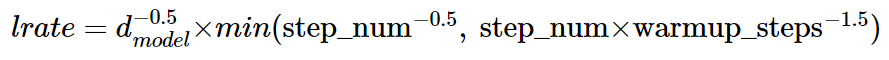


In [24]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

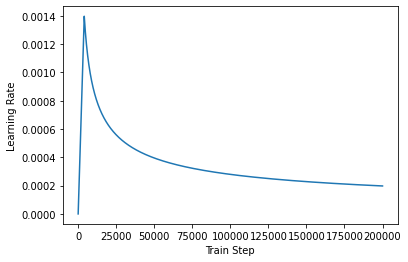

In [34]:
#커스텀 학습률 스케줄링 계획을 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 위의 코드들은 위키독스의 트랜스포머 세션을 참고했습니다.  
[Reference](https://wikidocs.net/31379)  

### 6-13.모델 컴파일
●손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일  
●optimizer는 Adam으로 정의 

In [48]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

fst_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])#모델 컴파일

### 6-14.훈련하기

In [49]:
fst_history = fst_model.fit(dataset, epochs=50)

Epoch 1/50
185/185 [==============================] - 15s 52ms/step - loss: 1.4572 - accuracy: 0.0210
Epoch 2/50
185/185 [==============================] - 10s 52ms/step - loss: 1.1767 - accuracy: 0.0494
Epoch 3/50
185/185 [==============================] - 10s 52ms/step - loss: 1.0049 - accuracy: 0.0507
Epoch 4/50
185/185 [==============================] - 10s 52ms/step - loss: 0.9299 - accuracy: 0.0545
Epoch 5/50
185/185 [==============================] - 10s 52ms/step - loss: 0.8716 - accuracy: 0.0577
Epoch 6/50
185/185 [==============================] - 10s 52ms/step - loss: 0.8119 - accuracy: 0.0618
Epoch 7/50
185/185 [==============================] - 10s 52ms/step - loss: 0.7455 - accuracy: 0.0676
Epoch 8/50
185/185 [==============================] - 10s 53ms/step - loss: 0.6713 - accuracy: 0.0756
Epoch 9/50
185/185 [==============================] - 10s 53ms/step - loss: 0.5925 - accuracy: 0.0846
Epoch 10/50
185/185 [==============================] - 10s 53ms/step - loss: 0.509

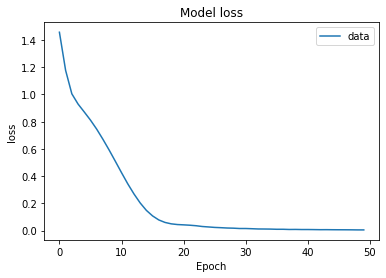

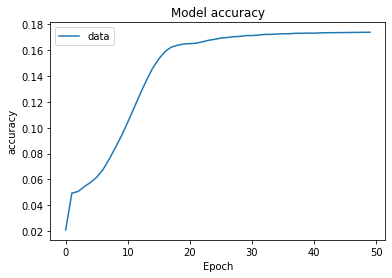

In [50]:
#history 시각화
def history_plot(met, history):
    plt.plot(history.history[met], label='data')
    plt.title('Model {}'.format(met))
    plt.xlabel('Epoch')
    plt.ylabel(met)
    plt.legend()
    plt.show()

history_plot('loss', fst_history)
history_plot('accuracy', fst_history)

시각화가 굳이 필요 없을 정도로 loss가 안정적으로 감소하고 accuracy는 안정적으로 증가합니다.  

In [22]:
tf.keras.backend.clear_session() #현재 tf 그래프를 없애고, 새로운 tf 그래프를 만듦, 오래된 모델 혹은 층과의 혼란을 피할 때 유용

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
D_MODEL = 128 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.3 # 드롭아웃의 비율

#트랜스포머 모델 정의
snd_model = transformer( 
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

snd_model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 128)    1840128     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [28]:
snd_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])#모델 컴파일
snd_history = snd_model.fit(dataset, epochs=50)

Epoch 1/50
185/185 [==============================] - 29s 58ms/step - loss: 1.5084 - accuracy: 0.0199
Epoch 2/50
185/185 [==============================] - 11s 57ms/step - loss: 1.3135 - accuracy: 0.0330
Epoch 3/50
185/185 [==============================] - 11s 57ms/step - loss: 1.1008 - accuracy: 0.0497
Epoch 4/50
185/185 [==============================] - 11s 57ms/step - loss: 1.0087 - accuracy: 0.0502
Epoch 5/50
185/185 [==============================] - 11s 57ms/step - loss: 0.9525 - accuracy: 0.0514
Epoch 6/50
185/185 [==============================] - 10s 57ms/step - loss: 0.9181 - accuracy: 0.0534
Epoch 7/50
185/185 [==============================] - 11s 57ms/step - loss: 0.8908 - accuracy: 0.0547
Epoch 8/50
185/185 [==============================] - 11s 58ms/step - loss: 0.8653 - accuracy: 0.0562
Epoch 9/50
185/185 [==============================] - 11s 58ms/step - loss: 0.8400 - accuracy: 0.0573
Epoch 10/50
185/185 [==============================] - 11s 57ms/step - loss: 0.813

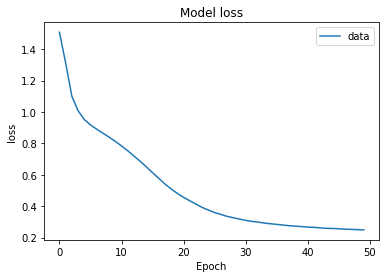

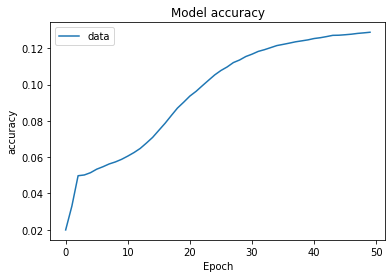

In [31]:
history_plot('loss', snd_history)
history_plot('accuracy', snd_history)

### 6-15.챗봇 평가하기  
총 세 가지 함수를 구현합니다. predict 함수에서 evaluate 함수를 호출하고 evaluate 함수에서 preprocess_sentence 함수를 호출하는 구조입니다.  
●<b>preprocess_sentence함수</b>  
문자열에 대한 전처리 수행, 앞에서 진행했던 입력 데이터 전처리와 동일한 방식  
●<b>evaluate함수</b>  
입력 데이터가 인코더와 디코더를 지나 최종적으로 예측한 단어인데 문자열이 아닌 정수 시퀀스 이므로 이를 단어로 다시 변환시켜주는 함수가 필요  
●<b>predict함수</b>  
evaluate의 결과로 출력된 정수 시퀀스를 문자열로 다시 decoding을 하고 챗봇의 대답을 출력함  



In [32]:
def preprocess_sentence(sentence):
    # 단어와 구두점 사이에 공백 추가.
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip() #양쪽 공백 제거 
    return sentence

def evaluate(sentence):
    # 입력 문장에 대한 전처리
    sentence = preprocess_sentence(sentence)

    # 입력 문장에 시작 토큰과 종료 토큰을 추가
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 예측 시작
    for i in range(MAX_LENGTH):
        #predictions = fst_model(inputs=[sentence, output], training=False)
        predictions = snd_model(inputs=[sentence, output], training=False)
        
        # 현재 시점의 예측 단어를 받아온다.
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 시점의 예측 단어가 종료 토큰이라면 예측을 중단
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 현재 시점의 예측 단어를 output(출력)에 연결한다.
        # output은 for문의 다음 루프에서 디코더의 입력이 된다.
        output = tf.concat([output, predicted_id], axis=-1)

    # 단어 예측이 모두 끝났다면 output을 리턴.
    return tf.squeeze(output, axis=0) #tf.squeeze:차원 중 사이즈가 1인 것을 찾아 스칼라값으로 바꿔 해당 차원을 제거한다. 

def predict(sentence):
    prediction = evaluate(sentence)

    # prediction == 디코더가 리턴한 챗봇의 대답에 해당하는 정수 시퀀스
    # tokenizer.decode()를 통해 정수 시퀀스를 문자열로 디코딩.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

### 첫번째 하이퍼파라미터 적용한 결과  

In [56]:
q = []
a = []

In [57]:
output = predict("행복해") #고마워
q.append("행복해")
a.append(output)

Input: 행복해
Output: 행복할 거라 생각해요 .


In [58]:
output = predict("잘지내") #오오
q.append("잘지내")
a.append(output)

Input: 잘지내
Output: 잘 지낼 거예요 .


In [59]:
output = predict("12시 땡!") #그럴듯하다
q.append("12시 땡!")
a.append(output)

Input: 12시 땡!
Output: 하루가 또 가네요 .


In [60]:
output = predict("고민이 있어") #문제 해결 방법 제시 
q.append("고민이 있어")
a.append(output)

Input: 고민이 있어
Output: 저는 생각을 덜하려고 노력해요 .  다른 일에 집중하거나요 .


In [61]:
output = predict("너무 화가나")
q.append("너무 화가나")
a.append(output)

Input: 너무 화가나
Output: 그럴수록 당신이 힘들 거예요 .


In [62]:
output = predict("그 사람을 잊을 수 있을까?") #??
q.append("그 사람을 잊을 수 있을까?")
a.append(output)

Input: 그 사람을 잊을 수 있을까?
Output: 마음이 모두 맞춰줄 필요는 없어요 .


In [63]:
output = predict("힘들어") #대체로 참으란 얘기네
q.append("힘들어")
a.append(output)

Input: 힘들어
Output: 지금은 힘들겠지만 조금만 더 견뎌봐요 .


In [64]:
output = predict("우울해") #so sweet
q.append("우울해")
a.append(output)

Input: 우울해
Output: 많이 힘들었죠 .


In [65]:
output = predict("결혼이 중요해?") #oh my god. 현명하다
q.append("결혼이 중요해?")
a.append(output)

Input: 결혼이 중요해?
Output: 도피성 결혼은 하지 않길 바라요 .


In [66]:
output = predict("제가 이상한건가요?") #날 궁금해 하네 호오
q.append("제가 이상한건가요?")
a.append(output)

Input: 제가 이상한건가요?
Output: 한 번 말해보세요 .


In [67]:
output = predict("오랜만에 들어오네요 너무 힘이들어서") #긴 문장은 어색한 대답을 함 
q.append("오랜만에 들어오네요 너무 힘이들어서")
a.append(output)

Input: 오랜만에 들어오네요 너무 힘이들어서
Output: 후회하지 않을 자신이 있다면 안타깝게 생각해요 .


In [68]:
output = predict("헤어졌어") #ㅠㅠ
q.append("헤어졌어")
a.append(output)

Input: 헤어졌어
Output: 많이 힘들었겠어요 .


In [69]:
df1 = pd.DataFrame({'Q':q, 'A':a}) #최종 결과 데이터 프레임에 저장  
df1

,Q,A
0,행복해,행복할 거라 생각해요 .
1,잘지내,잘 지낼 거예요 .
2,12시 땡!,하루가 또 가네요 .
3,고민이 있어,저는 생각을 덜하려고 노력해요 . 다른 일에 집중하거나요 .
4,너무 화가나,그럴수록 당신이 힘들 거예요 .
5,그 사람을 잊을 수 있을까?,마음이 모두 맞춰줄 필요는 없어요 .
6,힘들어,지금은 힘들겠지만 조금만 더 견뎌봐요 .
7,우울해,많이 힘들었죠 .
8,결혼이 중요해?,도피성 결혼은 하지 않길 바라요 .
9,제가 이상한건가요?,한 번 말해보세요 .


### 두번째 하이퍼파라미터 적용  
동일한 질문을 두번째 모델에 적용했을 때의 결과를 출력하여 나중에 첫번째 모델의 결과와 비교하겠습니다.  

In [33]:
q2 = []
a2 = []

In [34]:
output = predict("행복해") #더 행복하라는 건가?
q2.append("행복해")
a2.append(output)

Input: 행복해
Output: 더 좋은 곳에서 살 수 있을 거예요 .


In [35]:
output = predict("잘지내") #sweet
q2.append("잘지내")
a2.append(output)

Input: 잘지내
Output: 제가 있잖아요 .


In [36]:
output = predict("12시 땡!") #학교 선생님 같네
q2.append("12시 땡!")
a2.append(output)

Input: 12시 땡!
Output: 좋은 생각이에요 .


In [37]:
output = predict("고민이 있어") #이건 좀 아닌거 같다 
q2.append("고민이 있어")
a2.append(output)

Input: 고민이 있어
Output: 좋은 소식이네요 .


In [38]:
output = predict("너무 화가나") #이건 좀 그럴듯하다
q2.append("너무 화가나")
a2.append(output)

Input: 너무 화가나
Output: 많이 지쳤나봐요 .


In [39]:
output = predict("그 사람을 잊을 수 있을까?") #오호
q2.append("그 사람을 잊을 수 있을까?")
a2.append(output)

Input: 그 사람을 잊을 수 있을까?
Output: 그 사람도 그럴 거예요 .


In [40]:
output = predict("힘들어") #??
q2.append("힘들어")
a2.append(output)

Input: 힘들어
Output: 좋은 생각이에요 .


In [41]:
output = predict("우울해") #아니 우울하다구!
q2.append("우울해")
a2.append(output)

Input: 우울해
Output: 좋은 선택입니다 .


In [42]:
output = predict("결혼이 중요해?") #이쯤되면 두번째 하이퍼파라미터가 엉망인가 본데...
q2.append("결혼이 중요해?")
a2.append(output)

Input: 결혼이 중요해?
Output: 사랑은 끝나도 당신의 시간은 여전히 진행 중인 걸 잊지 마세요 .


In [43]:
output = predict("제가 이상한건가요?")  #내가 이상하다고??
q2.append("제가 이상한건가요?")
a2.append(output)

Input: 제가 이상한건가요?
Output: 그런 경우가 아무래도 많겠죠 .


In [44]:
output = predict("오랜만에 들어오네요 너무 힘이들어서") #긴 문장은 어색한 대답을 함 
q2.append("오랜만에 들어오네요 너무 힘이들어서")
a2.append(output)

Input: 오랜만에 들어오네요 너무 힘이들어서
Output: 좋은 선택입니다 .


In [45]:
output = predict("헤어졌어") #sweet
q2.append("헤어졌어")
a2.append(output)

Input: 헤어졌어
Output: 제가 있잖아요 .


In [46]:
df2 = pd.DataFrame({'Q':q2, 'A':a2}) #최종 결과 데이터 프레임에 저장  
df2

,Q,A
0,행복해,더 좋은 곳에서 살 수 있을 거예요 .
1,잘지내,제가 있잖아요 .
2,12시 땡!,좋은 생각이에요 .
3,고민이 있어,좋은 소식이네요 .
4,너무 화가나,많이 지쳤나봐요 .
5,그 사람을 잊을 수 있을까?,그 사람도 그럴 거예요 .
6,힘들어,좋은 생각이에요 .
7,우울해,좋은 선택입니다 .
8,결혼이 중요해?,사랑은 끝나도 당신의 시간은 여전히 진행 중인 걸 잊지 마세요 .
9,제가 이상한건가요?,그런 경우가 아무래도 많겠죠 .


# Result&Discussion  
●첫번째 하이퍼파라미터 세트가 두번째 하이퍼파라미터 세트 보다 더 나은 성능을 보인다.  
●짧은 문장에 더 그럴듯한 대답을 하고 긴 문장은 엉뚱한 대답을 하는 패턴을 보인다.  
●해당 데이터셋이 사람을 위로하는 취지로 만들어졌기 때문에 효과를 테스트하기 위해선 위로가 필요한 질문을 하는게 좋을 것 같았다.  
  꽤 괜찮은 대답을 한 경우도 있었고 어색한 문장이 출력된 경우도 있었다.  
●더 많은 시도를 하지 못한건 아쉽지만 덕분에 트랜스포머의 이론과 코드를 자세히 뜯어보는 기회가 되었다.  